# PSL: Regression Splines

## Load Libraries

Let’s delve into fitting a regression spline model in Python. After loading necessary libraries. We include two pivotal functions: bs and ns. These functions allow us to generate the design matrix for cubic splines and natural cubic splines respectively.

In [1]:
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt

from scipy.interpolate import splev, interp1d
from sklearn.linear_model import LinearRegression

In [2]:
# ref: https://github.com/pydata/patsy/blob/6bd31ca7f5f12e77a918681d14b7c28d931bde38/patsy/splines.py
def bs(x, df=None, knots=None, boundary_knots=None, degree=3, include_intercept=False):
    ord = 1 + degree

    if boundary_knots is None:
        boundary_knots = [np.min(x), np.max(x)]
    else:
        boundary_knots = np.sort(boundary_knots).tolist()

    oleft = x < boundary_knots[0]
    oright = x > boundary_knots[1]
    outside = oleft | oright
    inside = ~outside

    if df is not None:
        nIknots = df - ord + (1 - include_intercept)
        if nIknots < 0:
            nIknots = 0

        if nIknots > 0:
            knots = np.linspace(0, 1, num=nIknots + 2)[1:-1]
            knots = np.quantile(x[~outside], knots)

    Aknots = np.sort(np.concatenate((boundary_knots * ord, knots)))
    n_bases = len(Aknots) - (degree + 1)
    if any(outside):
        # print("some 'x' values beyond boundary knots may cause ill-conditioned bases")
        scalef = sp.special.gamma(np.arange(1, ord + 1))[:, None]  # factorials
        basis = np.empty((x.shape[0], n_bases), dtype=float)
        # in theory anything in (0, 1); was (implicitly) 0 in R <= 3.2.2
        e = 1 / 4

        if any(oleft):
            # left pivot inside, i.e., a bit to the right of the boundary knot
            k_pivot = (1 - e) * boundary_knots[0] + e * Aknots[ord]
            xl = np.power.outer(x[oleft] - k_pivot, np.arange(1, degree + 1))
            xl = np.c_[np.ones(xl.shape[0]), xl]

            # equivalent to splineDesign(Aknots, rep(k.pivot, ord), ord, derivs)
            tt = np.empty((xl.shape[1], n_bases), dtype=float)
            for j in range(xl.shape[1]):
                for i in range(n_bases):
                    coefs = np.zeros((n_bases,))
                    coefs[i] = 1
                    tt[j, i] = splev(k_pivot, (Aknots, coefs, degree), der=j)

            basis[oleft, :] = xl @ (tt / scalef)

        if any(oright):
            # right pivot inside, i.e., a bit to the left of the boundary knot
            k_pivot = (1 - e) * boundary_knots[1] + \
                e * Aknots[len(Aknots) - ord - 1]
            xr = np.power.outer(x[oright] - k_pivot, np.arange(1, degree + 1))
            xr = np.c_[np.ones(xr.shape[0]), xr]

            # equivalent to splineDesign(Aknots, rep(k.pivot, ord), ord, derivs)
            tt = np.empty((xr.shape[1], n_bases), dtype=float)
            for j in range(xr.shape[1]):
                for i in range(n_bases):
                    coefs = np.zeros((n_bases,))
                    coefs[i] = 1
                    tt[j, i] = splev(k_pivot, (Aknots, coefs, degree), der=j)
            basis[oright, :] = xr @ (tt / scalef)

        if any(inside):
            xi = x[inside]
            tt = np.empty((len(xi), n_bases), dtype=float)
            for i in range(n_bases):
                coefs = np.zeros((n_bases,))
                coefs[i] = 1
                tt[:, i] = splev(xi, (Aknots, coefs, degree))
            basis[inside, :] = tt
    else:
        basis = np.empty((x.shape[0], n_bases), dtype=float)
        for i in range(n_bases):
            coefs = np.zeros((n_bases,))
            coefs[i] = 1
            basis[:, i] = splev(x, (Aknots, coefs, degree))

    if include_intercept is False:
        basis = basis[:, 1:]

    return basis


In [3]:
# converted from R's ns()
def ns(x, df=None, knots=None, boundary_knots=None, include_intercept=False):
    degree = 3
    
    if boundary_knots is None:
        boundary_knots = [np.min(x), np.max(x)]
    else:
        boundary_knots = np.sort(boundary_knots).tolist()

    oleft = x < boundary_knots[0]
    oright = x > boundary_knots[1]
    outside = oleft | oright
    inside = ~outside

    if df is not None:
        nIknots = df - 1 - include_intercept
        if nIknots < 0:
            nIknots = 0
            
        if nIknots > 0:
            knots = np.linspace(0, 1, num=nIknots + 2)[1:-1]
            knots = np.quantile(x[~outside], knots)

    Aknots = np.sort(np.concatenate((boundary_knots * 4, knots)))
    n_bases = len(Aknots) - (degree + 1)

    if any(outside):
        basis = np.empty((x.shape[0], n_bases), dtype=float)
        e = 1 / 4 # in theory anything in (0, 1); was (implicitly) 0 in R <= 3.2.2

        if any(oleft):
            k_pivot = boundary_knots[0]
            xl = x[oleft] - k_pivot
            xl = np.c_[np.ones(xl.shape[0]), xl]

            # equivalent to splineDesign(Aknots, rep(k.pivot, ord), ord, derivs)
            tt = np.empty((xl.shape[1], n_bases), dtype=float)
            for j in range(xl.shape[1]):
                for i in range(n_bases):
                    coefs = np.zeros((n_bases,))
                    coefs[i] = 1
                    tt[j, i] = splev(k_pivot, (Aknots, coefs, degree), der=j)

            basis[oleft, :] = xl @ tt

        if any(oright):
            k_pivot = boundary_knots[1]
            xr = x[oright] - k_pivot
            xr = np.c_[np.ones(xr.shape[0]), xr]

            tt = np.empty((xr.shape[1], n_bases), dtype=float)
            for j in range(xr.shape[1]):
                for i in range(n_bases):
                    coefs = np.zeros((n_bases,))
                    coefs[i] = 1
                    tt[j, i] = splev(k_pivot, (Aknots, coefs, degree), der=j)
                    
            basis[oright, :] = xr @ tt
        
        if any(inside):
            xi = x[inside]
            tt = np.empty((len(xi), n_bases), dtype=float)
            for i in range(n_bases):
                coefs = np.zeros((n_bases,))
                coefs[i] = 1
                tt[:, i] = splev(xi, (Aknots, coefs, degree))

            basis[inside, :] = tt
    else:
        basis = np.empty((x.shape[0], n_bases), dtype=float)
        for i in range(n_bases):
            coefs = np.zeros((n_bases,))
            coefs[i] = 1
            basis[:, i] = splev(x, (Aknots, coefs, degree))

    const = np.empty((2, n_bases), dtype=float)
    for i in range(n_bases):
        coefs = np.zeros((n_bases,))
        coefs[i] = 1
        const[:, i] = splev(boundary_knots, (Aknots, coefs, degree), der=2)

    if include_intercept is False:
        basis = basis[:, 1:]
        const = const[:, 1:]

    qr_const = np.linalg.qr(const.T, mode='complete')[0]
    basis = (qr_const.T @ basis.T).T[:, 2:]

    return basis
    

## Spline Basis Functions

To get a grasp on what the spline basis functions resemble, consider the scenario with five knots. This gives us a degree of freedom of nine, implying we should expect nine basis functions. These knots are equally spaced, and their locations are provided.

In [4]:
x = np.arange(0.01, 2, 0.01)
n = len(x)
m = 5
myknots = 2 * np.arange(1, m + 1) / (m + 1)
myknots

array([0.33333333, 0.66666667, 1.        , 1.33333333, 1.66666667])

In [5]:
X = np.vstack(([1.0] * n, x, x ** 2, x ** 3))
for i in range(m):
    tmp = (x - myknots[i]) ** 3
    tmp[tmp < 0] = 0
    X = np.vstack((X, tmp))

Among the nine basis functions referenced in the notes, the initial four represent the basis functions for global cubic polynomials: the intercept, x, x^2, and x^3. The latter five basis functions are truncated functions situated at each of the five knots. To the left of a given knot, the function remains at zero; to its right, it takes on a cubic form.

Visualizing these, the five knots appear as dashed lines representing the truncated cubic functions, while the solid lines denote the global cubic polynomial basis functions.

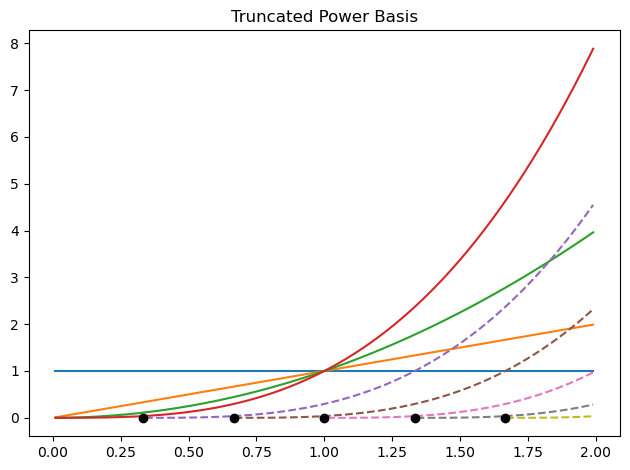

In [6]:
plt.figure()
plt.title("Truncated Power Basis")

for i in range(m + 4):
    tmp = X[i]
    if i < 4:
        mylty = '-'
    else:
        mylty = '--'
    plt.plot(x[tmp != 0], tmp[tmp != 0], linestyle=mylty)

for i in range(m):
    plt.plot(myknots[i], 0, "ok")

plt.tight_layout()

When using the bs command to generate the design matrix for a cubic spline with these knots, it creates a matrix with nine columns, considering the intercept. Each column corresponds to a basis function, giving rise to the B-spline basis functions. An advantage of B-splines is their compact support, ensuring functions are non-zero only within certain intervals. This results in a banded design matrix, where many elements are zero, streamlining computations.

In [7]:
F = bs(x, knots=myknots, include_intercept=True)
F.shape

(199, 9)

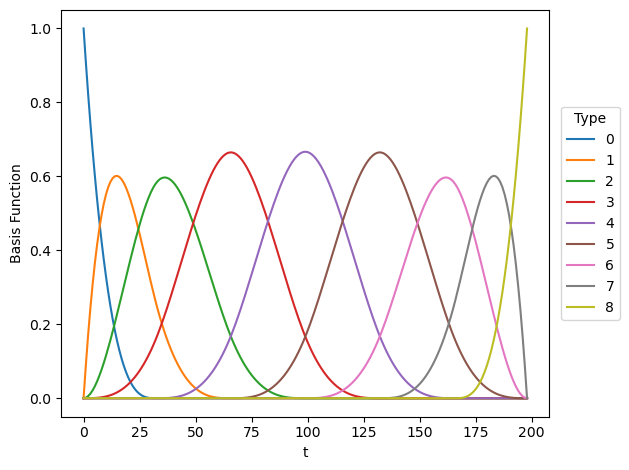

In [8]:
plt.plot(F)
plt.xlabel("t")
plt.ylabel("Basis Function")
plt.legend(range(9), title="Type",
           bbox_to_anchor=(1.01, 0.5), loc="center left")
plt.tight_layout()

If not setting `intercept = TRUE`, `bs` will return 9-1 = 8 columns.

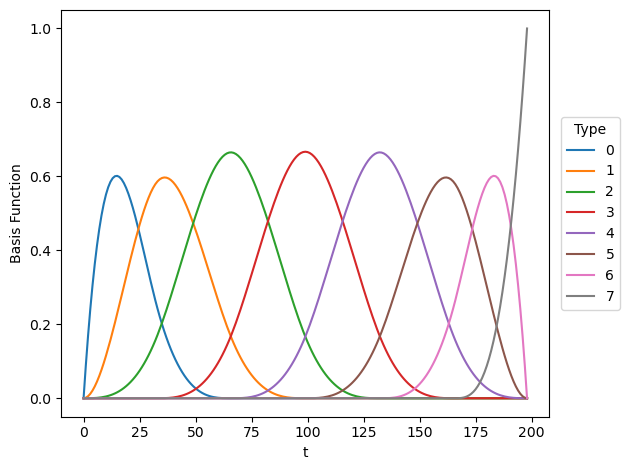

In [9]:
F = bs(x, knots=myknots, include_intercept=False)
plt.plot(F)
plt.xlabel("t")
plt.ylabel("Basis Function")
plt.legend(range(8), title="Type",
           bbox_to_anchor=(1.01, 0.5), loc="center left")
plt.tight_layout()

## NCS Basis Functions


To inspect the basis functions of a natural cubic spline, utilize the `ns` command. There are 7 basis functions for NCS with 7 knots (5 interior knots and 2 boundary knots).

In [10]:
F = ns(x, knots=myknots, boundary_knots=[0, 2], include_intercept=True)
F.shape

(199, 7)

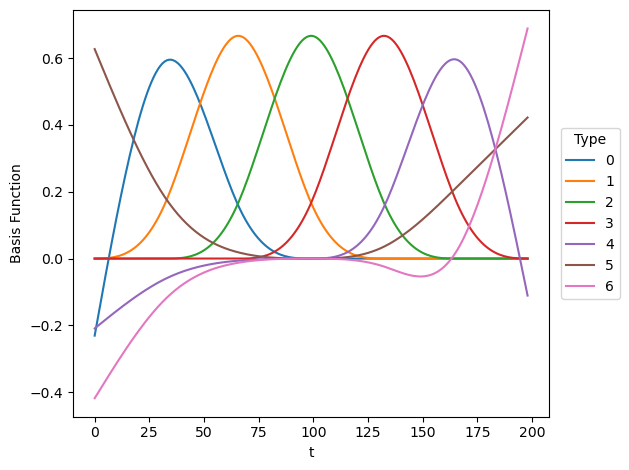

In [11]:
plt.plot(F)
plt.xlabel("t")
plt.ylabel("Basis Function")
plt.legend(range(7), title="Type",
           bbox_to_anchor=(1.01, 0.5), loc="center left")
plt.tight_layout()


## Regression Splines

### The Birthrate Data
Moving on, we'll apply regression splines to a dataset labeled "The Birthrate Data". This dataset documents the number of births per 2,000 people. Notable patterns include the birthrate dip during the Great Depression, followed by a rise leading up to World War II, and a subsequent gradual decline. There are evident spikes, possibly reflecting birth surges from the '60s impacting subsequent decades. An economist or social scientist might offer insights into this dataset's narrative. For our purposes, it serves as a practical example.

From a statistical standpoint, it's evident that a linear model isn't optimal for mapping years against rates. Regression splines might be a better fit.

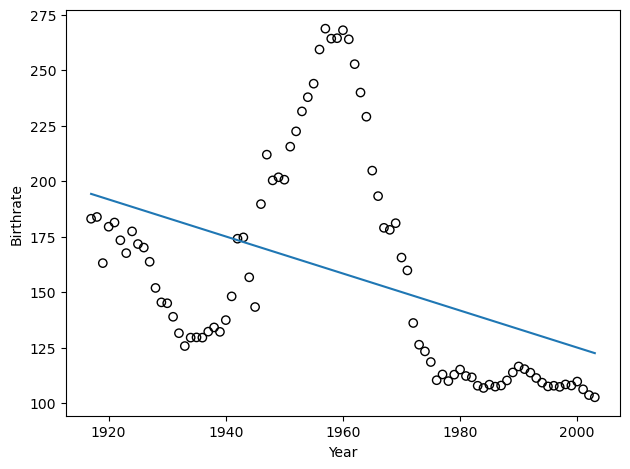

In [12]:
url = "https://liangfgithub.github.io/Data/birthrates.csv"
birthrates = pd.read_csv(url, sep=',')
m, b = np.polyfit(birthrates['Year'], birthrates['Birthrate'], 1)
plt.scatter(x='Year', y='Birthrate', data=birthrates, fc='none', ec='k')
plt.plot(birthrates['Year'], m * birthrates['Year'] + b)
plt.xlabel('Year')
plt.ylabel('Birthrate')
plt.tight_layout()

### How does R Count DF

We can use `bs` or `ns` to generate the design matrix F. 

You can either specify the location of knots directly or provide the desired degrees of freedom (df). 

- The relationship between df and the number of knots is straightforward: for a cubic spline with m knots, the corresponding df is m+4. 
- If you provide R with a df, it will determine the number of knots as df - 4. 
- By default, knots are placed at quantiles. For instance, if three knots are required, they will be positioned at the 25th, 50th, and 75th percentiles. 

However, The method (similar to R's method) of counting the df can be perplexing. In the commands, the term df actually denotes the number of columns in the design matrix returned by the command. If an intercept isn't included in the matrix (which is the default behavior), the df in the command will be the actual degree of freedom minus one.

Let's consider several commands to elucidate this. 

- For a command specifying two knots at particular quantiles, this equates to 2+4=6 degrees of freedom. But since the intercept is typically omitted, this command would produce an n-by-5 design matrix.
- When the df is set to five (and no intercept included), the actual degrees of freedom become six. Hence, it would place two knots, typically at the 1/3 and 2/3 quantiles. 

The subsequent code fit four spline models. Intriguingly, three of them are identical. The purpose is to help students comprehend how the degree of freedom is calculated. 

In [13]:
year = birthrates['Year']
y = birthrates['Birthrate']
X = bs(year, knots=np.quantile(year, [1/3, 2/3]))
fit1 = LinearRegression().fit(X, y).predict(X)

X = bs(year, df=5)
fit2 = LinearRegression().fit(X, y).predict(X)

X = bs(year, df=6, include_intercept=True)
fit3 = LinearRegression().fit(X, y).predict(X)

X = bs(year, df=5, include_intercept=True)
fit4 = LinearRegression().fit(X, y).predict(X)

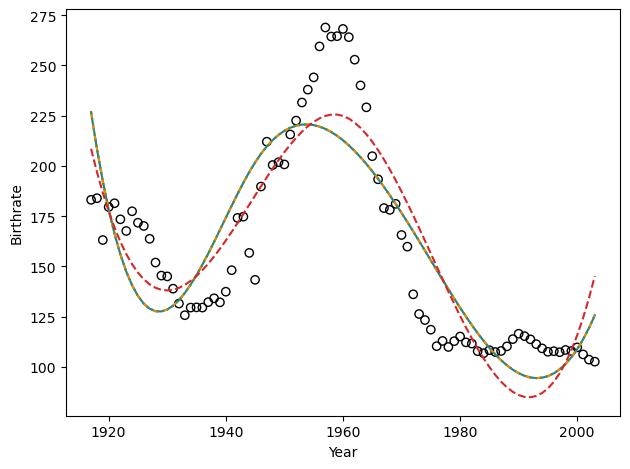

In [14]:
plt.scatter(x='Year', y='Birthrate', data=birthrates, fc='none', ec='k')
plt.plot(year, interp1d(x=year, y=fit1)(year))
plt.plot(year, interp1d(x=year, y=fit2)(year), '--')
plt.plot(year, interp1d(x=year, y=fit3)(year), ':')
plt.plot(year, interp1d(x=year, y=fit4)(year), '--')
plt.xlabel('Year')
plt.ylabel('Birthrate')
plt.tight_layout()

For natural cubic splines, there's an intriguing detail to consider. Let's examine an interval [a, b] populated with knots represented as $\xi_1, \xi_2, \dots, \xi_m$. 

The behavior of the functions at the two extreme intervals is uniquely determined by their neighboring functions. Specifically, the function spanning $[a, \xi_1]$ is governed by the behavior of the function within the interval  $[\xi_1, \xi_2]$. Why is this the case?

Within the interval  $[a, \xi_1]$, the function is linear and is determined by two parameters: its value and its 1st derivative at the boundary knot $\xi_1$. Due to the inherent continuity of spline functions (which preserves continuity up to the second derivative), both these parameters can be inferred from the function in the adjacent interval $[\xi_1, \xi_2]$. 

A similar relationship is seen for the function in the $[\xi_m, b]$, which is shaped by the function's characteristics in the $[\xi_{m-1}, \xi_m]$ interval. 

Hence, it's unnecessary to position data points in these outer intervals. By default, boundary knots are set to be $\xi_1$ and $\xi_m$ at the dataset's minimum and maximum values. And the option `knots` refers to interior knots. 

The subsequent code fit three NCS models. They are identical, corresponding to a NCS with 7 knots (or equivalently 7 df).

In [15]:
X = ns(year, knots=np.quantile(year, np.arange(1, 5) / 5))
fit1 = LinearRegression().fit(X, y).predict(X)

X = ns(year, df=5)
fit2 = LinearRegression().fit(X, y).predict(X)

X = ns(year, df=6, include_intercept=True)
fit3 = LinearRegression().fit(X, y).predict(X)

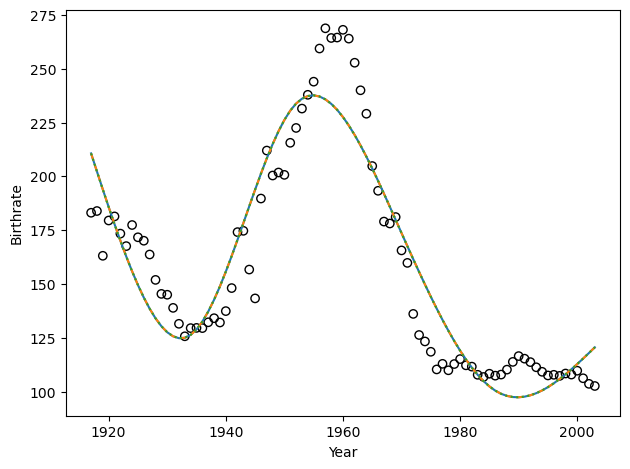

In [16]:
plt.scatter(x='Year', y='Birthrate', data=birthrates, fc='none', ec='k')
plt.plot(year, interp1d(x=year, y=fit1)(year))
plt.plot(year, interp1d(x=year, y=fit2)(year), '--')
plt.plot(year, interp1d(x=year, y=fit3)(year), ':')
plt.xlabel('Year')
plt.ylabel('Birthrate')
plt.tight_layout()


### Prediction

Make prediction outside the data range.

In [17]:
def bs_predict(new, x, df=None, knots=None, boundary_knots=None, degree=3, include_intercept=False):
    ord = 1 + degree

    if boundary_knots is None:
        boundary_knots = [np.min(x), np.max(x)]

    if df is not None:
        nIknots = df - ord + (1 - include_intercept)
        if nIknots < 0:
            nIknots = 0

        if nIknots > 0:
            knots = np.linspace(0, 1, num=nIknots + 2)[1:-1]
            knots = np.quantile(x, knots)

    basis = bs(new, df=df, knots=knots, boundary_knots=boundary_knots,
               degree=degree, include_intercept=include_intercept)

    return basis


In [18]:
def ns_predict(new, x, df=None, knots=None, boundary_knots=None, include_intercept=False):
    degree = 3

    if boundary_knots is None:
        boundary_knots = [np.min(x), np.max(x)]
    else:
        boundary_knots = np.sort(boundary_knots).tolist()

    if df is not None:
        nIknots = df - 1 - include_intercept
        if nIknots < 0:
            nIknots = 0

        if nIknots > 0:
            knots = np.linspace(0, 1, num=nIknots + 2)[1:-1]
            knots = np.quantile(x, knots)

    basis = ns(new, df=df, knots=knots, boundary_knots=boundary_knots,
               include_intercept=include_intercept)

    return basis


In [19]:
new = np.arange(1905, 2016)

X = bs(year, df=7)
X_new = bs_predict(new, year, df=7)
fit1 = LinearRegression().fit(X, y).predict(X_new)

X = ns(year, df=7)
X_new = ns_predict(new, year, df=7)
fit2 = LinearRegression().fit(X, y).predict(X_new)


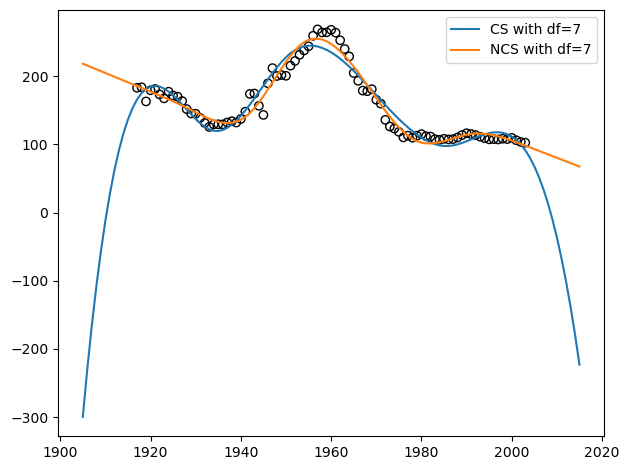

In [20]:
plt.plot(new, interp1d(x=new, y=fit1)(new))
plt.plot(new, interp1d(x=new, y=fit2)(new))
plt.legend(["CS with df=7", "NCS with df=7"], loc="upper right")
plt.scatter(x='Year', y='Birthrate', data=birthrates, fc='none', ec='k')
plt.tight_layout()


## Select DF 


The placement of knots significantly influences the performance of a spline model. However, handpicking the precise locations of these knots can be computationally burdensome. A more efficient strategy involves positioning the knots at quantiles of x, allowing us to focus solely on determining the optimal number of knots or, equivalently, the degrees of freedom (df). 

Try cubic splines with different degree-of-freedoms

In [17]:
X = bs(year, df=7)
fit1 = LinearRegression().fit(X, y).predict(X)

X = bs(year, df=14)
fit2 = LinearRegression().fit(X, y).predict(X)

X = bs(year, df=19)
fit3 = LinearRegression().fit(X, y).predict(X)


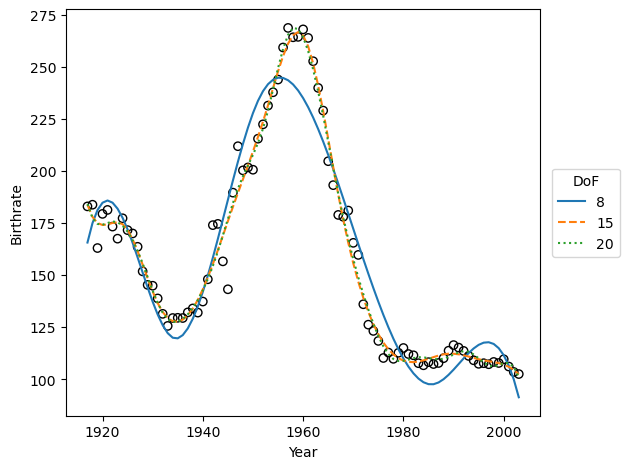

In [18]:
plt.plot(year, interp1d(x=year, y=fit1)(year))
plt.plot(year, interp1d(x=year, y=fit2)(year), '--')
plt.plot(year, interp1d(x=year, y=fit3)(year), ':')
plt.legend([8, 15, 20], title="DoF",
           bbox_to_anchor=(1.01, 0.5), loc="center left")
plt.scatter(x='Year', y='Birthrate', data=birthrates, fc='none', ec='k')
plt.xlabel('Year')
plt.ylabel('Birthrate')
plt.tight_layout()


Recall that we use hypothesis testing to determine the optimal polynomial degree. The process involves iteratively increasing the polynomial degree. During each iteration, we utilize the t-test (which effectively acts as an F-test) to contrast two models: the current model and a bigger model with one degree more.

Can we utilize this same F-test approach to select the optimal number of knots in spline regression? The answer is "No." The primary reason being that the models being compared in this context are not nested. Consequently, the F-test, which relies on comparing nested models, is unsuitable for this specific purpose.

To address this, we employ 10-fold CV. We start with dividing the data into 10 folds.

In [23]:
K = 10
n = birthrates.shape[0]
fold_size = np.concatenate(([9] * 7, [8] * 3))
fold_id = np.repeat(np.arange(0, K), fold_size)
fold_id


array([0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 7, 7, 7,
       7, 7, 7, 7, 7, 8, 8, 8, 8, 8, 8, 8, 8, 9, 9, 9, 9, 9, 9, 9, 9])

In [24]:
fold_id = np.random.choice(fold_id, n)
fold_id


array([7, 0, 0, 9, 6, 3, 8, 2, 6, 8, 1, 9, 2, 3, 0, 7, 8, 1, 5, 1, 0, 4,
       9, 4, 5, 0, 5, 2, 5, 4, 8, 3, 9, 7, 3, 6, 0, 4, 7, 0, 5, 3, 0, 5,
       7, 6, 2, 4, 3, 3, 2, 6, 8, 7, 8, 1, 5, 4, 1, 9, 5, 8, 3, 4, 3, 9,
       6, 2, 1, 6, 9, 6, 5, 4, 4, 6, 2, 2, 3, 6, 1, 6, 5, 7, 5, 4, 8])

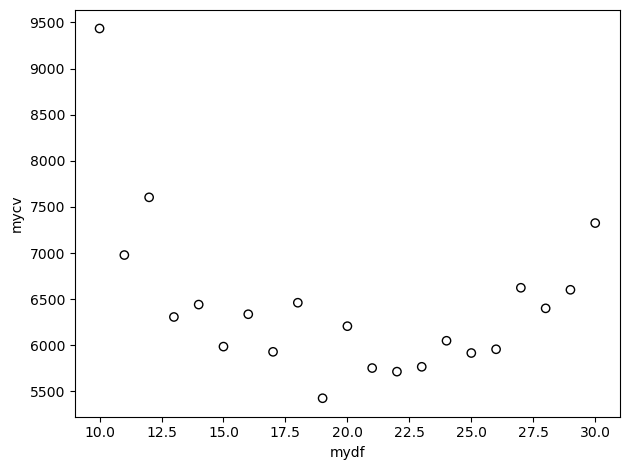

In [25]:
mydf = np.arange(10, 31)
mycv = np.zeros(len(mydf))

for i in range(len(mydf)):
    m = mydf[i] - 4
    for k in range(K):
        mask = (fold_id == k)
        myknots = np.quantile(year[~mask], np.arange(1, m + 1) / (m + 1))
        myy = y[~mask].to_numpy()
        myX = bs(year[~mask], knots=myknots)
        myX_new = bs_predict(year[mask].to_numpy(),
                             year[~mask].to_numpy(), knots=myknots)
        myfit = LinearRegression().fit(myX, myy).predict(myX_new)
        mycv[i] += np.sum((myfit - y[mask]) ** 2.0)

plt.scatter(mydf, mycv, fc='none', ec='k')
plt.xlabel('mydf')
plt.ylabel('mycv')
plt.tight_layout()


Re-run the 10-fold CV. The plot of `mydf` versus `mycv` may vary, but shouldn't be too different.

In [26]:
k = 0
mask = (fold_id == k)
myknots = np.quantile(year[~mask], np.arange(1, m + 1) / (m + 1))
myy = y[~mask].to_numpy()
myX = bs(year[~mask], knots=myknots)
myX_new = bs_predict(year[mask].to_numpy(),
                     year[~mask].to_numpy(), knots=myknots)
myfit = LinearRegression().fit(myX, myy).predict(myX_new)
mycv[i] += np.sum((myfit - y[mask]) ** 2.0)


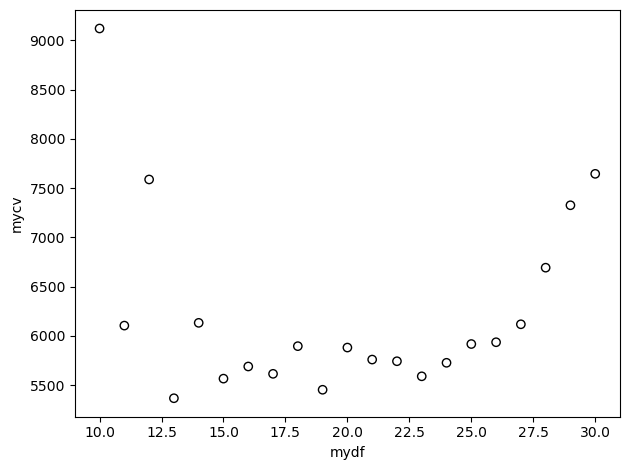

In [27]:
fold_id = np.random.choice(fold_id, n)
fold_id

mydf = np.arange(10, 31)
mycv = np.zeros(len(mydf))

for i in range(len(mydf)):
    m = mydf[i] - 4
    for k in range(K):
        mask = (fold_id == k)
        myknots = np.quantile(year[~mask], np.arange(1, m + 1) / (m + 1))
        myy = y[~mask].to_numpy()
        myX = bs(year[~mask], knots=myknots)
        myX_new = bs_predict(year[mask].to_numpy(),
                             year[~mask].to_numpy(), knots=myknots)
        myfit = LinearRegression().fit(myX, myy).predict(myX_new)
        mycv[i] += np.sum((myfit - y[mask]) ** 2.0)

plt.scatter(mydf, mycv, fc='none', ec='k')
plt.xlabel('mydf')
plt.ylabel('mycv')
plt.tight_layout()
